## SFR package example
Demonstrates functionality of Flopy SFR module using the example documented by [Prudic and others (2004)](http://pubs.er.usgs.gov/publication/ofr20041042):  

#### Problem description:

* Grid dimensions: 1 Layer, 15 Rows, 10 Columns  
* Stress periods: 1 steady  
* Flow package: LPF  
* Stress packages: SFR, GHB, EVT, RCH  
* Solver: SIP  

<img src="./img/Prudic2004_fig6.png" width="400" height="500"/>

In [1]:
import sys
import platform
import os
import numpy as np
import glob
import shutil
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
    
import flopy.utils.binaryfile as bf
from flopy.utils.sfroutputfile import SfrFile

mpl.rcParams['figure.figsize'] = (11, 8.5)

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('pandas version: {}'.format(pd.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

flopy is installed in /Users/jdhughes/Documents/Development/flopy_git/flopy_fork/flopy
3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 14:38:56) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.17.3
pandas version: 0.25.2
matplotlib version: 3.1.1
flopy version: 3.2.13


In [2]:
#Set name of MODFLOW exe
#  assumes executable is in users path statement
exe_name = 'mf2005'
if platform.system() == 'Windows':
    exe_name += '.exe'

#### copy over the example files to the working directory

In [3]:
path = 'data'
if os.path.isfile(path):
    os.remove(path)
elif os.path.isdir(path):
    shutil.rmtree(path)
os.mkdir(path)
gpth = os.path.join('..', 'data', 'mf2005_test', 'test1ss.*')
for f in glob.glob(gpth):
    shutil.copy(f, path)
gpth = os.path.join('..', 'data', 'mf2005_test', 'test1tr.*')
for f in glob.glob(gpth):
    shutil.copy(f, path)

### Load example dataset, skipping the SFR package

In [4]:
m = flopy.modflow.Modflow.load('test1ss.nam', version='mf2005', exe_name=exe_name, 
                               model_ws=path, load_only=['ghb', 'evt', 'rch', 'dis', 'bas6', 'oc', 'sip', 'lpf'])

In [5]:
oc = m.oc
oc.stress_period_data

{(-1, -1): [],
 (0, 0): ['print budget', 'print head', 'save head', 'save budget']}

### Read pre-prepared reach and segment data into numpy recarrays using numpy.genfromtxt()
Reach data (Item 2 in the SFR input instructions), are input and stored in a numpy record array  
http://docs.scipy.org/doc/numpy/reference/generated/numpy.recarray.html  
This allows for reach data to be indexed by their variable names, as described in the SFR input instructions.

For more information on Item 2, see the Online Guide to MODFLOW:  
<http://water.usgs.gov/nrp/gwsoftware/modflow2000/MFDOC/index.html?sfr.htm>

In [6]:
rpth = os.path.join('..', 'data', 'sfr_examples', 'test1ss_reach_data.csv')
reach_data = np.genfromtxt(rpth, delimiter=',', names=True)
reach_data

array([(0.,  0., 0., 1., 1., 4500.), (0.,  1., 1., 1., 2., 7000.),
       (0.,  2., 2., 1., 3., 6000.), (0.,  2., 3., 1., 4., 5550.),
       (0.,  3., 4., 2., 1., 6500.), (0.,  4., 5., 2., 2., 5000.),
       (0.,  5., 5., 2., 3., 5000.), (0.,  6., 5., 2., 4., 5000.),
       (0.,  7., 5., 2., 5., 5000.), (0.,  2., 4., 3., 1., 5000.),
       (0.,  2., 5., 3., 2., 5000.), (0.,  2., 6., 3., 3., 4500.),
       (0.,  3., 7., 3., 4., 6000.), (0.,  4., 7., 3., 5., 5000.),
       (0.,  5., 7., 3., 6., 2000.), (0.,  4., 9., 4., 1., 2500.),
       (0.,  4., 8., 4., 2., 5000.), (0.,  5., 7., 4., 3., 3500.),
       (0.,  5., 7., 5., 1., 4000.), (0.,  6., 6., 5., 2., 5000.),
       (0.,  7., 6., 5., 3., 3500.), (0.,  7., 5., 5., 4., 2500.),
       (0.,  8., 5., 6., 1., 5000.), (0.,  9., 6., 6., 2., 5000.),
       (0., 10., 6., 6., 3., 5000.), (0., 11., 6., 6., 4., 5000.),
       (0., 12., 6., 6., 5., 2000.), (0., 13., 8., 7., 1., 5000.),
       (0., 12., 7., 7., 2., 5500.), (0., 12., 6., 7., 3., 500

### Segment Data structure
Segment data are input and stored in a dictionary of record arrays, which 

In [7]:
spth = os.path.join('..', 'data', 'sfr_examples', 'test1ss_segment_data.csv')
ss_segment_data = np.genfromtxt(spth, delimiter=',', names=True)
segment_data = {0: ss_segment_data}
segment_data[0][0:1]['width1']

array([0.])

### define dataset 6e (channel flow data) for segment 1
dataset 6e is stored in a nested dictionary keyed by stress period and segment,  
with a list of the following lists defined for each segment with icalc == 4  
FLOWTAB(1) FLOWTAB(2) ... FLOWTAB(NSTRPTS)  
DPTHTAB(1) DPTHTAB(2) ... DPTHTAB(NSTRPTS)  
WDTHTAB(1) WDTHTAB(2) ... WDTHTAB(NSTRPTS)  

In [8]:
channel_flow_data = {0: {1: [[0.5, 1.0, 2.0, 4.0, 7.0, 10.0, 20.0, 30.0, 50.0, 75.0, 100.0],
                             [0.25, 0.4, 0.55, 0.7, 0.8, 0.9, 1.1, 1.25, 1.4, 1.7, 2.6],
                             [3.0, 3.5, 4.2, 5.3, 7.0, 8.5, 12.0, 14.0, 17.0, 20.0, 22.0]]}}

### define dataset 6d (channel geometry data) for segments 7 and 8
dataset 6d is stored in a nested dictionary keyed by stress period and segment,  
with a list of the following lists defined for each segment with icalc == 4  
FLOWTAB(1) FLOWTAB(2) ... FLOWTAB(NSTRPTS)  
DPTHTAB(1) DPTHTAB(2) ... DPTHTAB(NSTRPTS)  
WDTHTAB(1) WDTHTAB(2) ... WDTHTAB(NSTRPTS)  

In [9]:
channel_geometry_data = {0: {7: [[0.0, 10.0, 80.0, 100.0, 150.0, 170.0, 240.0, 250.0],
                                 [20.0, 13.0, 10.0, 2.0, 0.0, 10.0, 13.0, 20.0]],
                             8: [[0.0, 10.0, 80.0, 100.0, 150.0, 170.0, 240.0, 250.0],
                                 [25.0, 17.0, 13.0, 4.0, 0.0, 10.0, 16.0, 20.0]]}}

### Define SFR package variables  

In [10]:
nstrm = len(reach_data) # number of reaches
nss = len(segment_data[0]) # number of segments
nsfrpar = 0 # number of parameters (not supported)
nparseg = 0
const = 1.486 # constant for manning's equation, units of cfs
dleak = 0.0001 # closure tolerance for stream stage computation
ipakcb = 53 # flag for writing SFR output to cell-by-cell budget (on unit 53)
istcb2 = 81 # flag for writing SFR output to text file
dataset_5 = {0: [nss, 0, 0]} # dataset 5 (see online guide)

### Instantiate SFR package  
Input arguments generally follow the variable names defined in the Online Guide to MODFLOW

In [11]:
sfr = flopy.modflow.ModflowSfr2(m, nstrm=nstrm, nss=nss, const=const, dleak=dleak, ipakcb=ipakcb, istcb2=istcb2, 
                                reach_data=reach_data,
                                segment_data=segment_data,
                                channel_geometry_data=channel_geometry_data,
                                channel_flow_data=channel_flow_data,
                                dataset_5=dataset_5, unit_number=15)

In [12]:
sfr.reach_data[0:1]

rec.array([(0, 0, 0, 0, 1, 1, 4500., 0., 0., 0., 0., 0., 0., 0., 0., 1, 2)],
          dtype=[('node', '<i8'), ('k', '<i8'), ('i', '<i8'), ('j', '<i8'), ('iseg', '<i8'), ('ireach', '<i8'), ('rchlen', '<f4'), ('strtop', '<f4'), ('slope', '<f4'), ('strthick', '<f4'), ('strhc1', '<f4'), ('thts', '<f4'), ('thti', '<f4'), ('eps', '<f4'), ('uhc', '<f4'), ('reachID', '<i8'), ('outreach', '<i8')])

### Plot the SFR segments
any column in the reach_data array can be plotted using the ```key``` argument

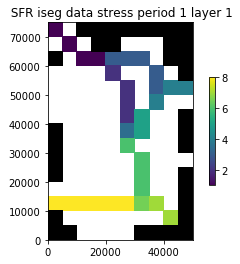

In [13]:
sfr.plot(key='iseg');

### Check the SFR dataset for errors

In [14]:
chk = sfr.check()

passed.

Checking for continuity in segment and reach numbering...
passed.

Checking for increasing segment numbers in downstream direction...
passed.

Checking for circular routing...
passed.

No DIS package or SpatialReference object; cannot check reach proximities.

Checking for model cells with multiple non-zero SFR conductances...
3 model cells with multiple non-zero SFR conductances found.
This may lead to circular routing between collocated reaches.
Nodes with overlapping conductances:
k	i	j	iseg	ireach	rchlen	strthick	strhc1
0	7	5	2	5	5000.0	3.0	2.9999999242136255e-05
0	5	7	3	6	2000.0	2.0	2.9999999242136255e-05
0	5	7	4	3	3500.0	3.0	2.9999999242136255e-05
0	5	7	5	1	4000.0	3.0	2.9999999242136255e-05
0	7	5	5	4	2500.0	3.0	2.9999999242136255e-05
0	12	6	6	5	2000.0	3.0	2.9999999242136255e-05
0	12	6	7	3	5000.0	3.0	5.999999848427251e-05

Checking for streambed tops of less than -10...
strtop not specified for isfropt=0
passed.

Checking for streambed tops of greater than 15000...
strtop

In [15]:
m.external_fnames = [os.path.split(f)[1] for f in m.external_fnames]
m.external_fnames

['test1ss.sg1',
 'test1ss.sg2',
 'test1ss.sg3',
 'test1ss.sg4',
 'test1ss.sg5',
 'test1ss.sg6',
 'test1ss.sg7',
 'test1ss.sg8',
 'test1ss.dvsg9']

In [16]:
m.write_input()

In [17]:
m.run_model()

FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: test1ss.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/11/15 17:46:48

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2019/11/15 17:46:48
 Elapsed run time:  0.020 Seconds

  Normal termination of simulation


(True, [])

### Load SFR formated water balance output into pandas dataframe using the `SfrFile` class 
* requires the **pandas** library

In [18]:
sfr_outfile = os.path.join('..', 'data', 'sfr_examples', 'test1ss.flw')
sfrout = SfrFile(sfr_outfile)
df = sfrout.get_dataframe()
df.head()

,layer,row,column,segment,reach,Qin,Qaquifer,Qout,Qovr,Qprecip,Qet,stage,depth,width,Cond,gradient,kstpkper,k,i,j
0,1,1,1,1,1,25.0000,0.7923,24.2080,0.0,0.0,0.0,1094.22,1.174,12.98,0.5843,0.4520,"(0, 0)",0,0,0
1,1,2,2,1,2,24.2080,2.1408,22.0670,0.0,0.0,0.0,1089.21,1.152,12.68,0.8878,0.8038,"(0, 0)",0,1,1
2,1,3,3,1,3,22.0670,2.9909,19.0760,0.0,0.0,0.0,1083.53,1.110,12.13,0.7278,1.3700,"(0, 0)",0,2,2
3,1,3,4,1,4,19.0760,2.5538,16.5220,0.0,0.0,0.0,1078.47,1.064,11.32,0.6285,1.3550,"(0, 0)",0,2,3
4,1,4,5,2,1,6.5222,2.7058,3.8163,0.0,0.0,0.0,1072.40,0.469,12.00,0.7800,1.1560,"(0, 0)",0,3,4


#### Plot streamflow and stream/aquifer interactions for a segment

9     1
10    2
11    3
12    4
13    5
14    6
Name: reach, dtype: object


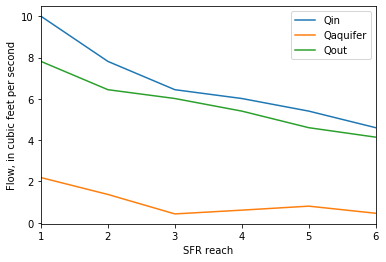

In [19]:
inds = df.segment == 3
print(df.reach[inds].astype(str))
#ax = df.ix[inds, ['Qin', 'Qaquifer', 'Qout']].plot(x=df.reach[inds])
ax = df.loc[inds, ['reach', 'Qin', 'Qaquifer', 'Qout']].plot(x='reach')
ax.set_ylabel('Flow, in cubic feet per second')
ax.set_xlabel('SFR reach');

### Look at stage, model top, and streambed top

In [20]:
streambed_top = m.sfr.segment_data[0][m.sfr.segment_data[0].nseg == 3][['elevup', 'elevdn']][0]
streambed_top

(1075., 1060.)

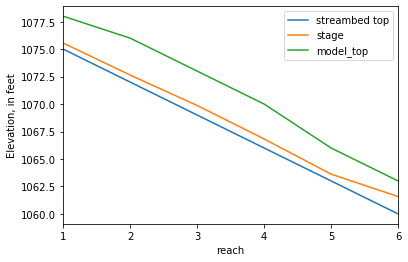

In [21]:
df['model_top'] = m.dis.top.array[df.row.values - 1, df.column.values -1]
fig, ax = plt.subplots()
plt.plot([1, 6], list(streambed_top), label='streambed top')
#ax = df.loc[inds, ['stage', 'model_top']].plot(ax=ax, x=df.reach[inds])
ax = df.loc[inds, ['reach', 'stage', 'model_top']].plot(ax=ax, x='reach')
ax.set_ylabel('Elevation, in feet')
plt.legend();

### Get SFR leakage results from cell budget file

In [22]:
bpth = os.path.join('data', 'test1ss.cbc')
cbbobj = bf.CellBudgetFile(bpth)
cbbobj.list_records()

(1, 1, b'  STREAM LEAKAGE', 10, 15, 1, 0, 0., 0., -1., b'', b'', b'', b'')


In [23]:
sfrleak = cbbobj.get_data(text='  STREAM LEAKAGE')[0]
sfrleak[sfrleak == 0] = np.nan # remove zero values

### Plot leakage in plan view

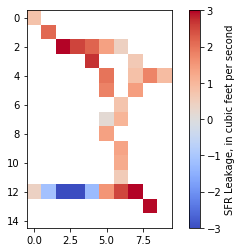

In [24]:
im = plt.imshow(sfrleak[0], interpolation='none', cmap='coolwarm', vmin = -3, vmax=3)
cb = plt.colorbar(im, label='SFR Leakage, in cubic feet per second');

### Plot total streamflow

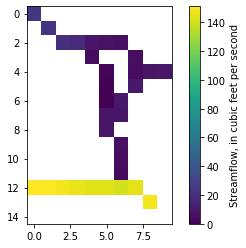

In [25]:
sfrQ = sfrleak[0].copy()
sfrQ[sfrQ == 0] = np.nan
sfrQ[df.row.values-1, df.column.values-1] = df[['Qin', 'Qout']].mean(axis=1).values
im = plt.imshow(sfrQ, interpolation='none')
plt.colorbar(im, label='Streamflow, in cubic feet per second');

## Reading transient SFR formatted output
the `SfrFile` class handles this the same way

files for the transient version of the above example were already copied to the `data` folder in the third cell above
first run the transient model to get the output:
```
>mf2005 test1tr.nam
```

In [26]:
flopy.run_model(exe_name, 'test1tr.nam', model_ws=path, silent=True)

(True, [])

In [27]:
sfrout_tr = SfrFile(os.path.join('data', 'test1tr.flw'))
dftr = sfrout_tr.get_dataframe()
dftr.head()

,layer,row,column,segment,reach,Qin,Qaquifer,Qout,Qovr,Qprecip,Qet,stage,depth,width,Cond,gradient,kstpkper,k,i,j
0,1,1,1,1,1,25.0000,0.77759,24.2220,0.0,0.0,0.0,1094.22,1.1740,12.98,0.5843,0.4436,"(0, 0)",0,0,0
1,1,2,2,1,2,24.2220,2.21540,22.0070,0.0,0.0,0.0,1089.21,1.1510,12.68,0.8875,0.8321,"(0, 0)",0,1,1
2,1,3,3,1,3,22.0070,2.98700,19.0200,0.0,0.0,0.0,1083.53,1.1090,12.12,0.7270,1.3700,"(0, 0)",0,2,2
3,1,3,4,1,4,19.0200,2.54940,16.4710,0.0,0.0,0.0,1078.47,1.0630,11.31,0.6275,1.3540,"(0, 0)",0,2,3
4,1,4,5,2,1,6.4706,2.70370,3.7669,0.0,0.0,0.0,1072.40,0.4663,12.00,0.7800,1.1550,"(0, 0)",0,3,4


### plot a hydrograph
plot `Qout` (simulated streamflow) and `Qaquifer` (simulated stream leakage) through time

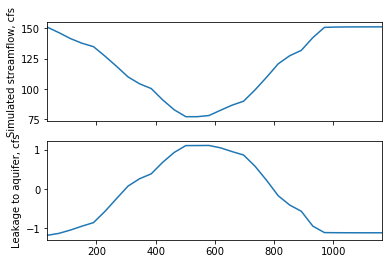

In [28]:
fig, axes = plt.subplots(2, 1, sharex=True)
dftr8 = dftr.loc[(dftr.segment == 8) & (dftr.reach == 5)]
dftr8.Qout.plot(ax=axes[0])
axes[0].set_ylabel('Simulated streamflow, cfs')
dftr8.Qaquifer.plot(ax=axes[1])
axes[1].set_ylabel('Leakage to aquifer, cfs');